# Group 13 - Yelp Review Analysis for Module 3 
Group members:
- Jonquil Liao
- Yuhan Zhou
- Yike Wang

In [2]:
# import initial modules
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
# read in reviews from previous notebook
data = pd.read_csv('review_steakhouse.csv')

In [5]:
data['review_length'] = data.text.map(len)

In [6]:
import numpy as np
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re, string
import sys
import time
import collections
from array import array

In [7]:
badreviews = data[(data.stars_x <= 2 )]
goodreviews = data[(data.stars_x >= 4)]
badreviews = badreviews.text
goodreviews = goodreviews.text
print('Postive Reviews:  {:,}'.format(len(goodreviews)))
print('Negative Reviews:  {:,}'.format(len(badreviews)))

Postive Reviews:  17,270
Negative Reviews:  7,284


In [8]:
badreviews = ["".join([char for char in a if char not in string.punctuation]) for a in badreviews]
goodreviews = ["".join([char for char in a if char not in string.punctuation]) for a in goodreviews]

In [9]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'just', 'us','great',
               'good','best','nice','always','back','ever',
               'ive','go','well','not','bad','terrible',
               'don', 'really', 'said', 'told', 'ok','dont',
               'came', 'went', 'did', 'didn','one','would']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [10]:
text1=badreviews
text1 = [a.lower() for a in text1]
words1 = [nltk.word_tokenize(a) for a in text1]
filtered_words1 = [[word for word in a if word not in stop_words] for a in words1]
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [11]:
text2=goodreviews
text2 = [a.lower() for a in text2]
words2 = [nltk.word_tokenize(a) for a in text2]
filtered_words2 = [[word for word in a if word not in stop_words] for a in words2]

In [12]:
lemmatized_words1 = [[lmtzr.lemmatize(x) for x in a] for a in filtered_words1]
lemmatized_words2 = [[lmtzr.lemmatize(x) for x in a] for a in filtered_words2]

In [13]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
lemmatized_words1=[ ' '.join(map(str, sent)) for sent in lemmatized_words1]
lemmatized_words2=[ ' '.join(map(str, sent)) for sent in lemmatized_words2]

In [14]:
tfidf_model1 = TfidfVectorizer(stop_words=stop_words,
                        ngram_range=(1,1))
tfidf_model2 = TfidfVectorizer(stop_words=stop_words, 
                        ngram_range=(1,1))
result1=tfidf_model1.fit_transform(lemmatized_words1)
result2=tfidf_model2.fit_transform(lemmatized_words2)

In [15]:
bad_df = pd.DataFrame(result1.todense(), columns=[tfidf_model1.get_feature_names()])
good_df = pd.DataFrame(result2.todense(), columns=[tfidf_model2.get_feature_names()])
col_means_bad = {}
for col in bad_df:
    col_means_bad[col] = bad_df[col].mean()

col_means_good = {}
for col in good_df:
    col_means_good[col] = good_df[col].mean()
    
top_words = 8

print('Top words in good reviews:')
print(sorted(col_means_good, key=col_means_good.get, reverse=True)[:top_words])

print('Top words in bad reviews:')
print(sorted(col_means_bad, key=col_means_bad.get, reverse=True)[:top_words])

Top words in good reviews:
[('food',), ('service',), ('place',), ('steak',), ('time',), ('restaurant',), ('delicious',), ('bar',)]
Top words in bad reviews:
[('food',), ('steak',), ('service',), ('time',), ('place',), ('table',), ('restaurant',), ('ordered',)]


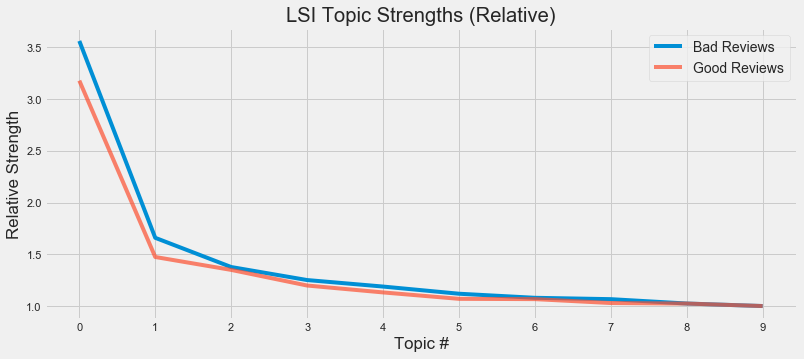

In [16]:
'This part credited to Ankur Vishwakarma, Oakland, CA. https://github.com/Vishwacorp/'
from gensim import corpora, models, similarities, matutils
corpus1 = matutils.Sparse2Corpus(result1.transpose())
corpus2 = matutils.Sparse2Corpus(result2.transpose())
word_bad = dict((v,k) for k,v in tfidf_model1.vocabulary_.items())
word_good = dict((v,k) for k,v in tfidf_model2.vocabulary_.items())
word_bad2 = corpora.Dictionary.from_corpus(corpus1, id2word=word_bad)
word_good2 = corpora.Dictionary.from_corpus(corpus2, id2word=word_good)
lsi_bad = models.LsiModel(corpus1, id2word=word_bad2, num_topics=10)
lsi_good = models.LsiModel(corpus2, id2word=word_good2, num_topics=10)

singular_values_bad = lsi_bad.projection.s.tolist()
singular_values_bad_rel = [sv/singular_values_bad[-1] for sv in singular_values_bad]
singular_values_good = lsi_good.projection.s.tolist()
singular_values_good_rel = [sv/singular_values_good[-1] for sv in singular_values_good]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_bad)), singular_values_bad_rel, label='Bad Reviews', alpha=1.0)
plt.plot(range(len(singular_values_good)), singular_values_good_rel, label='Good Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_bad)), range(len(singular_values_bad)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [17]:
import pprint
from pprint import pprint

In [18]:
no_top_words = 8

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_good, key=col_means_good.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_bad, key=col_means_bad.get, reverse=True)[:no_top_words])

Top 8 words in POSITIVE reviews:[('food',), ('service',), ('place',), ('steak',), ('time',), ('restaurant',), ('delicious',), ('bar',)]
Top 8 words in NEGATIVE reviews:[('food',), ('steak',), ('service',), ('time',), ('place',), ('table',), ('restaurant',), ('ordered',)]


### NMF <a name='s4'></a>

In [19]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 4

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(result2)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(result1)
H_neg = nmf_neg.components_

CPU times: user 5.79 s, sys: 86.2 ms, total: 5.87 s
Wall time: 1.57 s


In [32]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 8

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_model2.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.842*salad, 0.798*meat, 0.723*ordered, 0.637*bar, 0.637*delicious, 0.635*dinner, 0.626*table, 0.603*meal
Topic 1:   1.419*cheese, 1.271*curd, 1.161*burger, 0.990*old, 0.896*beer, 0.839*fashioned, 0.657*madison, 0.626*wisconsin
Topic 2:   1.706*food, 1.210*service, 0.802*place, 0.716*excellent, 0.685*atmosphere, 0.661*amazing, 0.550*staff, 0.525*recommend
Topic 3:   2.758*steak, 0.755*cooked, 0.443*perfectly, 0.386*house, 0.383*steakhouse, 0.351*service, 0.345*medium, 0.332*ribeye

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.155*minute, 1.118*table, 0.766*drink, 0.705*order, 0.577*time, 0.551*wait, 0.547*waited, 0.542*server
Topic 1:   2.008*steak, 0.795*medium, 0.603*rare, 0.435*cooked, 0.398*ordered, 0.285*filet, 0.256*cook, 0.234*cut
Topic 2:   0.796*salad, 0.543*ordered, 0.516*chicken, 0.484*cheese, 0.436*burger, 0.406*fry, 0.367*meat, 0.365*po

As expected, these topics are far more interpretable.  
* First two topics for positive reviews seem to be (1) salad and sides and (2) meals other than steak.
* First two topics for negative reviews seem to be (1) slow service and (2) temperature of steak (seems like thai food in this subset of data).

In [27]:
np.random.seed(3)
num_reviews = 15000
random_pos = np.random.choice(goodreviews, size=num_reviews)

In [28]:
np.random.seed(30)
num_reviews = 5000
random_neg = np.random.choice(badreviews, size=num_reviews)

### Review Similarity in NMF space <a name='s5'></a>

In [29]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

6287
At long last after years of hearing about this place I had the chance to eat a meal at Meat  Potatoes And it didnt disappoint

The atmosphere in here is really quite interesting  while the place definitely has the look of a modern and comfortable dining area theres lots of little inclusions in decor that make you think about shopping for fresh meat from your local butcher shop Its kind of hard to describe and has to be seen to be understood but rest assured the place looks wonderful and inviting

But lets be honest the food is what really matters here Meat  Potatoes is wellknown for serving delicious food And well they do If you want a great appetizer go for their grilled bread which tastes like homemade toasty goodness especially once you add on the fresh butter and jam that comes with it As for the main courses my friend had their special fish tacos made with tilapia and I went for a good ol lamb burger And yes both were quite excellent Something about the ingredients used in th

In [30]:
# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [30]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
Ive lived in Madison my entire life so the fact that I had not been to this establishment before last night is shocking to me From the moment we made reservations to when we were walking out after dinner the staff was so incredibly friendly and attentive 

We started out at the bar  which is still the original bar from 1929 with some refurbishing where Al Capone and John Dillinger and some other gangsters used to hang out 

We had The Godfather martini vodka pineapple juice and the Tommy Gun bourbon cherry juice  I recommend both

We were seated upstairs for dinner Our waitress told us a wellrehearsed history on the Wonder Bar and added that it is now considered a certified haunted establishment This is a thumbs up in my book Our steaks were made perfectly the salads and sides were just as good Try the cheesy hash browns Oh And as an appetizer get the crab cakes 

The prices are decent for the amount and quality of 

NMF seems to be working well and making good topics for us. But just to give it a shot, let's use CountVectorizer (instead of TFIDF) and try topic modeling through LDA. While slower, its use of a dirichlet prior can often give good results.

### Count Vectorizer <a name='s6'></a>

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 5000
cv_random_neg = np.random.choice(badreviews, size=num_reviews)
cv_random_pos = np.random.choice(goodreviews, size=num_reviews)

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [34]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

### LDA <a name='s7'></a>

In [35]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=4, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=4, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

CPU times: user 47.6 s, sys: 4.03 s, total: 51.6 s
Wall time: 1min 1s


In [36]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.016*"cheese" + 0.010*"place" + 0.010*"menu" + 0.009*"food" + 0.009*"bar" '
  '+ 0.008*"old" + 0.008*"service"'),
 (1,
  '0.016*"steak" + 0.012*"service" + 0.009*"food" + 0.009*"cooked" + '
  '0.009*"ordered" + 0.008*"restaurant" + 0.008*"time"'),
 (2,
  '0.013*"meat" + 0.012*"bar" + 0.010*"food" + 0.010*"place" + 0.010*"salad" + '
  '0.008*"chicken" + 0.008*"brunch"'),
 (3,
  '0.033*"food" + 0.022*"place" + 0.017*"service" + 0.010*"time" + '
  '0.009*"atmosphere" + 0.008*"love" + 0.008*"burger"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.015*"time" + 0.015*"service" + 0.014*"minutes" + 0.012*"place" + '
  '0.010*"order" + 0.009*"table" + 0.008*"restaurant"'),
 (1,
  '0.014*"service" + 0.012*"steak" + 0.008*"ordered" + 0.008*"bar" + '
  '0.008*"place" + 0.008*"restaurant" + 0.007*"meal"'),
 (2,
  '0.015*"steak" + 0.014*"ordered" + 0.012*"salad" + 0.

In this case, it seems that our LDA topics are more blended together into each other than the ones generated by NMF. Let's move forward with NMF.

### Continuing with NMF Topics <a name='s8'></a>

In [37]:
%%time
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos,tfidf_model2.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.842*salad, 0.798*meat, 0.723*ordered, 0.637*bar, 0.637*delicious, 0.635*dinner, 0.626*table, 0.603*meal
Topic 1:   1.419*cheese, 1.271*curd, 1.161*burger, 0.990*old, 0.896*beer, 0.839*fashioned, 0.657*madison, 0.626*wisconsin
Topic 2:   1.706*food, 1.210*service, 0.802*place, 0.716*excellent, 0.685*atmosphere, 0.661*amazing, 0.550*staff, 0.525*recommend
Topic 3:   2.758*steak, 0.755*cooked, 0.443*perfectly, 0.386*house, 0.383*steakhouse, 0.351*service, 0.345*medium, 0.332*ribeye
CPU times: user 51.6 ms, sys: 8.29 ms, total: 59.9 ms
Wall time: 58.2 ms


In [38]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #14584
-------------------------
Visited Cleveland for a football game and loved the city  We wanted to eat somewhere nice for dinner and really loved this restaurant  Being from Texas the steak and lobster tail was truly amazing and felt like I was back home It was so delicious  The staff were accommodating and helped picked what was good off the menu I cant wait to go again
-------------------------
Topic 2: 0.0776
Topic 0: 0.0000
Topic 1: 0.0000
Topic 3: 0.0000


In [39]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.155*minute, 1.118*table, 0.766*drink, 0.705*order, 0.577*time, 0.551*wait, 0.547*waited, 0.542*server
Topic 1:   2.008*steak, 0.795*medium, 0.603*rare, 0.435*cooked, 0.398*ordered, 0.285*filet, 0.256*cook, 0.234*cut
Topic 2:   0.796*salad, 0.543*ordered, 0.516*chicken, 0.484*cheese, 0.436*burger, 0.406*fry, 0.367*meat, 0.365*potato
Topic 3:   1.672*food, 1.235*service, 1.037*place, 0.577*time, 0.434*slow, 0.425*price, 0.404*restaurant, 0.396*better


In [41]:
len(random_neg)

5000

In [40]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #3980
-------------------------
UPDATE  Woke up with gastrointestinal discomfort and a sick feeling the morning after my meal at this place  I have adjusted my rating accordingly  Horribly mismanaged restaurant  Bottom line  The food was actually pretty decent when it finally arrived  Thats the only reason that this review gets two stars  UPDATED to 1 star after waking up sick from the meal  The wait staff was a mixture of new people like our server Zack who was eager to please and facing impossible odds and bad attitude people like the young woman who ignored us and when stopped by our party told us that we would be served by another person whom she would tell to come visit our table She never bothered to tell him and we stopped him ourselves after waiting over 20 minutes  And then there was the manager Anna who didnt look or act like a manager and who actually argued with us about our food and who made admonishing remarks to us when questioned about the food  

The pl

### Topic Modeling All Reviews <a name='s9'></a>  
At this point, we can see that our topics are relatively interpretable and match along with the reviews they're trying to categorize. Let's proceed with topic modeling all reviews and businesses using NMF.

In [42]:
print('Postive Reviews:  {:,}'.format(len(goodreviews)))
print('Negative Reviews:  {:,}'.format(len(badreviews)))

Postive Reviews:  17,270
Negative Reviews:  7,284


In [43]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_model1 = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_model2 = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get the vectors
neg_vectors = tfidf_model1.fit_transform(badreviews)
pos_vectors = tfidf_model2.fit_transform(goodreviews)

CPU times: user 1.42 s, sys: 37.1 ms, total: 1.45 s
Wall time: 1.47 s


In [44]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 4

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 6.96 s, sys: 89.8 ms, total: 7.05 s
Wall time: 1.88 s


In [46]:
no_topics = num_topics
no_top_words = 8

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_model2.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   0.902*bar, 0.687*salad, 0.676*meat, 0.662*menu, 0.614*ordered, 0.612*time, 0.606*dinner, 0.590*table
Topic 1:   1.614*cheese, 1.379*curds, 1.095*old, 0.931*fashioned, 0.741*burger, 0.730*beer, 0.710*madison, 0.679*wisconsin
Topic 2:   1.808*food, 1.323*service, 0.768*excellent, 0.757*place, 0.740*amazing, 0.734*atmosphere, 0.580*staff, 0.554*recommend
Topic 3:   2.416*steak, 0.993*cooked, 0.611*steaks, 0.601*perfectly, 0.496*medium, 0.495*filet, 0.470*ribeye, 0.453*rare

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   1.383*place, 1.230*service, 0.544*better, 0.495*restaurant, 0.454*time, 0.420*quality, 0.413*slow, 0.388*bar
Topic 1:   1.930*steak, 0.889*medium, 0.663*rare, 0.458*cooked, 0.441*ordered, 0.441*steaks, 0.294*filet, 0.247*cook
Topic 2:   1.095*minutes, 0.901*table, 0.629*order, 0.556*waited, 0.552*time, 0.552*took, 0.545*asked, 0.544*wait
Topic 3:   0.794*salad, 0.

In [47]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Quality of vegetable salads and meat products', 1:'Atmosphere and service', 
              2:'Quality of other main courses', 3:'Quality of Steaks'}

neg_topics = {0:'Service quality', 1:'Cooking of steaks', 2:'Service--Waiting time', 
              3:'Quality of other sides and snacks'}

### Adding Topic Weights to Pandas DataFrame <a name='s10'></a>

In [48]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = data[['business_id', 'stars_x', 'text', 'review_length']][data.stars_x>3].reset_index()
df_neg = data[['business_id', 'stars_x', 'text', 'review_length']][data.stars_x<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

Our topic weights are not immediately relevant as absolute numbers. Let's take a look. 

In [49]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.0147518  0.01360633 0.01912921 0.        ]
Sum of weights:  0.04748734068758632


To a business owner, it does not make sense that that a review they received is 0.016 topic 0 and all their topics sum up to 0.043. Therefore, we can normalize the weights so they all add up to 1. 

In [50]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.31064709 0.28652537 0.40282754 0.        ]]
Sum of normalized weights:  1.0


In [51]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [52]:
# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,stars_x,text,review_length,0,1,2,3
0,JhxI7oS_jsFnq34dDubugQ,2,Rocky River location. Out of four different en...,425,0.370769,0.208862,0.0,0.420369
1,zLnmmB9jiKg-A2Lggs64-A,1,"Not worth the price. Service was OK... ""Poop e...",64,1.000000,0.000000,0.0,0.000000
2,7ddnq3YQSKguGK15etqGLQ,2,We decided on short notice to try the new Ditk...,942,0.268717,0.474638,0.0,0.256645
3,zLnmmB9jiKg-A2Lggs64-A,2,Came here for the ayce seafood buffet what a d...,442,0.356683,0.080516,0.0,0.562801
4,lpxj6LFir23Ds6swW8a6fg,1,Tourist trap. Like a bad cafeteria on top of M...,60,0.889444,0.110556,0.0,0.000000


Great - we have topic weights for each review in this dataframe. Next, we can group by the business_id and get mean topic weights per restaurant.

In [53]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'stars_x':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars_x':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean'}).reset_index()

In [54]:
df_pos_bsns.head(5)

,business_id,stars_x,text,review_length,0,1,2,3
0,-RQCdTsH5rkG702auLcEqA,4.400000,20,481.650000,0.427615,0.088054,0.298410,0.185921
1,-bHpvkmiFzm_swHLYsGiqw,4.659091,88,540.954545,0.391409,0.065747,0.416740,0.126104
2,0YA3RpY5KXcezPXcjdfOGQ,5.000000,1,491.000000,0.295324,0.000000,0.160068,0.544608
3,0gbi6kYiAOnFwfZ_2_dXSA,4.528090,89,574.000000,0.326692,0.059585,0.309239,0.304484
4,0grgvnq4GgoY-estWytUhg,4.475410,61,657.360656,0.452900,0.080191,0.400969,0.065940


In [55]:
df_neg_bsns.head()

,business_id,stars_x,text,review_length,0,1,2,3
0,-RQCdTsH5rkG702auLcEqA,1.400000,10,991.500000,0.322119,0.201204,0.146290,0.330387
1,-bHpvkmiFzm_swHLYsGiqw,1.520000,25,700.480000,0.523008,0.107491,0.149387,0.220114
2,0YA3RpY5KXcezPXcjdfOGQ,1.200000,5,446.800000,0.400840,0.393089,0.110761,0.095310
3,0gbi6kYiAOnFwfZ_2_dXSA,1.692308,13,965.615385,0.251634,0.263862,0.191868,0.292636
4,0grgvnq4GgoY-estWytUhg,1.586207,29,968.137931,0.391294,0.030168,0.170351,0.408187


### Adding in Business Information <a name='s11'></a>

In [56]:
# we can read in business info from a saved CSV file
# and add that to our last dataframe
steak_df = pd.read_csv('review_steakhouse.csv')
steak_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
steak_df=steak_df.drop(columns=['user_id','stars_x','useful','text','address',"postal_code","attributes","categories"])

In [57]:
steak_df.head()

,business_id,name,city,state,stars_y
0,lpxj6LFir23Ds6swW8a6fg,Grandview Saloon,Pittsburgh,PA,3.0
1,d6VYQbeTZ_WdD8Uuhh35dg,Tempest Oyster Bar,Madison,WI,4.0
2,szGbmw_vq3kVU4SfK1x6Sw,Ruths Chris Steak House,Pittsburgh,PA,4.0
3,eF2jf-E5ktRQIh_4_-Jxsg,Cannon's Chop House,Canonsburg,PA,3.5
4,JhxI7oS_jsFnq34dDubugQ,Ferris Steak House,Cleveland,OH,3.5


In [60]:
steakid=steak_df.groupby('business_id').apply(lambda x: x)
steakid=steakid.drop_duplicates()
steakid.head()

,business_id,name,city,state,stars_y
0,lpxj6LFir23Ds6swW8a6fg,Grandview Saloon,Pittsburgh,PA,3.0
1,d6VYQbeTZ_WdD8Uuhh35dg,Tempest Oyster Bar,Madison,WI,4.0
2,szGbmw_vq3kVU4SfK1x6Sw,Ruths Chris Steak House,Pittsburgh,PA,4.0
3,eF2jf-E5ktRQIh_4_-Jxsg,Cannon's Chop House,Canonsburg,PA,3.5
4,JhxI7oS_jsFnq34dDubugQ,Ferris Steak House,Cleveland,OH,3.5


In [67]:
test=df_pos_bsns.groupby(by=['business_id'])[0,1,2,3].sum()
test.head()

<ipython-input-67-a3f6ee3d699e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test=df_pos_bsns.groupby(by=['business_id'])[0,1,2,3].sum()


,0,1,2,3
business_id,,,,
-RQCdTsH5rkG702auLcEqA,0.455453,0.267870,0.090952,0.185724
-bHpvkmiFzm_swHLYsGiqw,0.405884,0.383983,0.071390,0.138743
0YA3RpY5KXcezPXcjdfOGQ,0.275592,0.272366,0.000000,0.452042
0gbi6kYiAOnFwfZ_2_dXSA,0.316093,0.315641,0.058682,0.309584
0grgvnq4GgoY-estWytUhg,0.489593,0.321819,0.098266,0.090322


In [65]:
df_pos_tot = df_pos_bsns.merge(steakid[['business_id','name', 'city', 'stars_y']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city','stars_y', 0, 1, 2, 3]]

df_neg_tot = df_neg_bsns.merge(steakid[[ 'business_id','name', 'city', 'stars_y']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city','stars_y', 0, 1, 2, 3]]

In [63]:
# peek into business/topic distributions
#df_pos_tot.head()
df_pos_tot.head()

,business_id,name,city,stars_y,0,1,2,3
0,-RQCdTsH5rkG702auLcEqA,Hoss's Steak & Sea House,Murrysville,3.5,0.427615,0.088054,0.298410,0.185921
1,-bHpvkmiFzm_swHLYsGiqw,Ken Stewart's Grille,Akron,4.0,0.391409,0.065747,0.416740,0.126104
2,0YA3RpY5KXcezPXcjdfOGQ,Pittsburgh Steak Company,Pittsburgh,2.0,0.295324,0.000000,0.160068,0.544608
3,0gbi6kYiAOnFwfZ_2_dXSA,Hyde Park Prime Steakhouse,Beachwood,4.0,0.326692,0.059585,0.309239,0.304484
4,0grgvnq4GgoY-estWytUhg,Timpone's,Urbana,3.5,0.452900,0.080191,0.400969,0.065940


We can check topic distributions for a business and see how they make sense after all the reviews have been normalized and then averaged up to the business-level. Let's check `business_id 'uOPzOiwkS_6w4txA7fYfeA'`, which happens to be a popular chili spot in Ohio.

In [66]:
scores = df_pos_bsns[df_pos_bsns.business_id == '-bHpvkmiFzm_swHLYsGiqw'].iloc[:,-6:].values
print(steakid[steakid.business_id == '-bHpvkmiFzm_swHLYsGiqw']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in pos_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))

Ken Stewart's Grille - Positive Reviews
------------------------------------
Topic 0: Quality of vegetable salads and meat products > 88.0000
Topic 1: Atmosphere and service > 540.9545
Topic 2: Quality of other main courses > 0.3914
Topic 3: Quality of Steaks  > 0.0657


We now have 4 dataframes:  
1. **`df_pos_tot`: ** topic distribution of positive reviews with name, city, and stars for all restaurants
2. **`df_neg_tot`: ** topic distribution of negative reviews with name, city, and stars for all restaurants
3. **`df_pos`: ** topic distribution of all positive reviews with associated business_id
4. **`df_neg`: ** topic distribution of all negative reviews with associated business_id  

We can write them to CSV files and then use that information for visualizations in Tableau.

In [68]:
%%time
# write to CSV
df_pos_tot.to_csv('outputcsv/pos_bsns.csv')
df_neg_tot.to_csv('outputcsv/neg_bsns.csv')

CPU times: user 11.2 ms, sys: 3.83 ms, total: 15 ms
Wall time: 15.7 ms
